In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import xarray as xa
import h5py    
import pandas as pd
import os
import re
import yaml

fig_path = '/home/dm/uni/ccees/seminar/analysis/figures/'
name_convention = 'E_seed_test-'

config_file = '../config/run_cfg.yml'


#### Load the Config File
But first replace ! for sweep with # 

In [2]:
%%bash -s "$config_file" 
sed -i 's/!/#/g' $1

Load the yml file. 

In [3]:
with open(config_file, 'r') as f:
    cfg = yaml.load(f)

<ipython-input-3-d3c0db5e0f73>:2: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  cfg = yaml.load(f)


Print out the cfg file:

In [4]:
cfg

{'parameter_space': {'num_steps': 4000,
  'write_every': 1,
  'seed': {'default': 42, 'values': [42, 2, 50]},
  'MyFancySeirModel': {'create_graph': {'model': 'ErdosRenyi',
    'num_vertices': {'default': 10, 'values': [10, 50, 100, 150]},
    'mean_degree': 2},
   'lockdown_time': -1,
   'local_lockdown': {'enabled': False,
    'close_threshold': 1.0,
    'open_threshold': 1.0},
   'random_infection_parameters': {'enabled': False,
    'randomize': ['beta'],
    'enable_variance_around_mean': True,
    'percentage': 0.1},
   'init_random_weight': True,
   'init_weight': 0.01,
   's_weight': 1,
   'e_weight': 1,
   'i_weight': 1,
   'r_weight': 1,
   'd_weight': 0}}}

Get seeds and vertices

In [5]:
num_vertices = cfg['parameter_space']['MyFancySeirModel']['create_graph']['num_vertices']['values']
seeds = cfg['parameter_space']['seed']['values']
num_steps = cfg['parameter_space']['num_steps']

In [6]:
no_seeds = len((seeds))
print(no_seeds)
no_vertices = len((num_vertices))
print(no_vertices)

3
4


In [7]:
universe_paths =  !find uni*/data*

In [8]:
universe_paths

['uni05/data.h5',
 'uni06/data.h5',
 'uni07/data.h5',
 'uni09/data.h5',
 'uni10/data.h5',
 'uni11/data.h5',
 'uni13/data.h5',
 'uni14/data.h5',
 'uni15/data.h5',
 'uni17/data.h5',
 'uni18/data.h5',
 'uni19/data.h5']

In [59]:
#regex = re.compile('uni*')
#universes = list(filter(regex.search, [name for name in os.listdir(".") if os.path.isdir(name)]))

In [9]:
universe_data = []
for uni in universe_paths:
    file_name = uni
    universe_data.append(h5py.File(uni , 'r+'))

no_universe = len(universe_data)

In [10]:
universe_data

[<HDF5 file "data.h5" (mode r+)>,
 <HDF5 file "data.h5" (mode r+)>,
 <HDF5 file "data.h5" (mode r+)>,
 <HDF5 file "data.h5" (mode r+)>,
 <HDF5 file "data.h5" (mode r+)>,
 <HDF5 file "data.h5" (mode r+)>,
 <HDF5 file "data.h5" (mode r+)>,
 <HDF5 file "data.h5" (mode r+)>,
 <HDF5 file "data.h5" (mode r+)>,
 <HDF5 file "data.h5" (mode r+)>,
 <HDF5 file "data.h5" (mode r+)>,
 <HDF5 file "data.h5" (mode r+)>]

In [36]:
ref_data_shape = universe_data[0]['MyFancySeirModel']['SEIR_reference'].shape
ref_data = np.empty((ref_data_shape[0], ref_data_shape[1], no_universe ))
for i in range(no_universe):
    ref_data[:, :, i] = universe_data[i]['MyFancySeirModel']['SEIR_reference'][()] 

In [37]:
#comps = ['D', 'E', 'I', 'N', 'R', 'S']
comps = ['D', 'E', 'I', 'R', 'S']
no_comps = len(comps)
sim_data = []
no_uni_vertices = np.empty(no_universe)
for i in range(no_universe):
    shape = universe_data[i]['MyFancySeirModel']['g_static']['D'].shape
    no_uni_vertices[i] = shape[1]
    comp_data = np.empty((shape[0], shape[1],  len(comps)))
    for (j, comp) in enumerate(comps):
        comp_data[:, :, j] = universe_data[i]['MyFancySeirModel']['g_static'][comp]
    sim_data.append(comp_data)

In [38]:
sim_Sdata = []

for uni in range(no_universe):
    sim_Sdata.append(np.sum(sim_data[uni], axis=1))

#### Infection Wave function

In [117]:
def find_infection_wave(I_ts, idx = 0 ):
    tmax = idx + np.argmax(I_ts[idx:])
    vmax = I_ts[int(tmax)]
    return [tmax, vmax]
idx_secwave = 2000

Average over seeds:

In [133]:
avg_sim_Sdata = []
std_sim_Sdata = []
first_infection_wave = np.empty((no_vertices, 2, no_seeds))
second_infection_wave = np.empty((no_vertices, 2, no_seeds))
for v in range(no_vertices):
    shape = (num_steps + 1, no_comps, no_seeds)
    V = np.empty(shape)
    
    for s in range(no_seeds):
        V[:, :, s] = sim_Sdata[v*no_seeds + s]
        first_infection_wave[v, :, s] = find_infection_wave(V[:, 2, s])
        second_infection_wave[v, :, s] = find_infection_wave(V[:, 2, s], idx=idx_secwave)
    
    mean = np.mean(V, axis=2)
    std = np.std(V, axis=2)
    
    avg_sim_Sdata.append(mean)
    std_sim_Sdata.append(std)

In [137]:
mean_first_infection_wave = np.mean(first_infection_wave, axis=2)
mean_second_infection_wave = np.mean(second_infection_wave, axis=2)
std_first_infection_wave = np.std(second_infection_wave, axis=2)
std_second_infection_wave = np.std(second_infection_wave, axis=2)

##### Average and Std of SEIR reference model

In [132]:
ref_data.shape

(4001, 5, 12)

In [198]:
avg_ref_data= []
std_ref_data = []
ref_first_infection_wave = np.empty((no_vertices, 2, no_seeds))
ref_second_infection_wave = np.empty((no_vertices, 2, no_seeds))

for v in range(no_vertices):
    p = v * no_seeds
    for s in range(no_seeds):
        ref_first_infection_wave[v, :, s] = find_infection_wave(ref_data[:, 2, v*no_seeds + s])
        ref_second_infection_wave[v, :, s] = find_infection_wave(ref_data[:, 2, v*no_seeds + s], idx=idx_secwave)
        
    avg_ref_data.append(np.mean(ref_data[:, :, p:p+no_seeds], axis=2))
    std_ref_data.append(np.std(ref_data[:, :, p:p+no_seeds], axis=2))

In [140]:
mean_ref_first_infection_wave = np.mean(ref_first_infection_wave, axis=2)
mean_ref_second_infection_wave = np.mean(ref_second_infection_wave, axis=2)
std_ref_first_infection_wave = np.std(ref_second_infection_wave, axis=2)
std_ref_second_infection_wave = np.std(ref_second_infection_wave, axis=2)

In [209]:
mean_ref_inv = np.mean(1/ ref_first_infection_wave, axis=2)
std_ref_inv = np.std(1/ ref_first_infection_wave, axis=2)

mean_ref_inv_sec = np.mean(1/ ref_second_infection_wave, axis=2)
std_ref_inv_sec = np.std(1/ ref_second_infection_wave, axis=2)

In [21]:
len(avg_ref_data)
print(avg_ref_data[3].shape)

(4001, 5)


In [50]:
sim_Sdata[0].shape

(4001, 5)

In [69]:
avg_ref_data[0].shape

(4001, 5)

###  Number of Vertices


In [28]:
ref_names = ['S', 'E', 'I', 'R', 'D']

#### Confidence Interval Total Population Plot

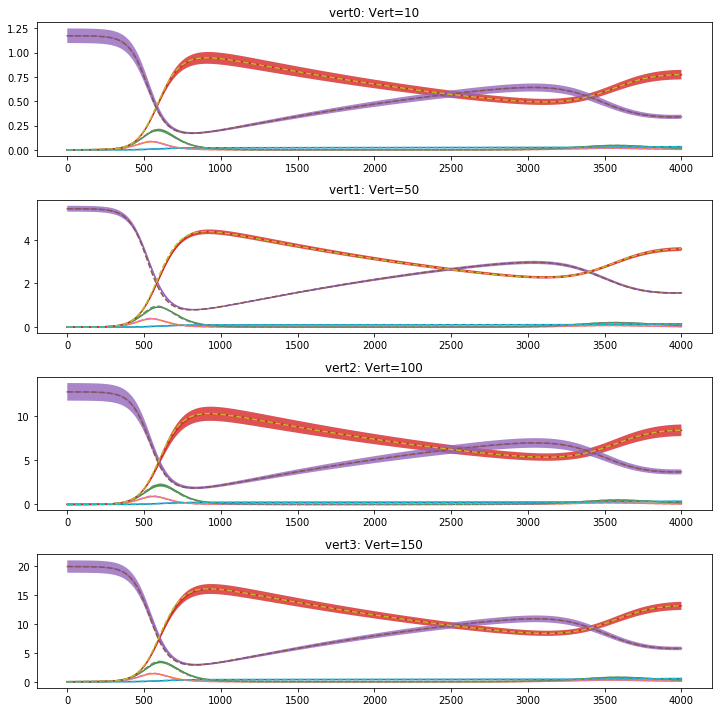

In [91]:
vertsweep_fig, ax = plt.subplots(no_vertices, 1, figsize=(10,10))
ax = ax.flatten()

for vert in range(no_vertices):
    for comp in range(len(comps)):
        ci = 1.96 * std_sim_Sdata[vert][:, comp] / no_seeds
        y = avg_sim_Sdata[vert][:,comp]
        ax[vert].plot(y, label=comps[comp])
        ax[vert].fill_between(np.arange(4001),(y-ci), (y+ci), alpha=0.8)
        
        
    
    for i in range(ref_data.shape[1]):
        ax[vert].plot(avg_ref_data[vert][:, i], '--', label='{}'.format(ref_names[i]))
    
    ax[vert].set_title('vert{}: Vert={}'.format(vert,num_vertices[vert]))
    #ax[vert].legend()
        
plt.tight_layout()

### Dependency of Infection Waves on Vertices in Network

#### Visualize Infection Waves for all vertices

In [123]:
mean_first_infection_wave.shape

(4, 2)

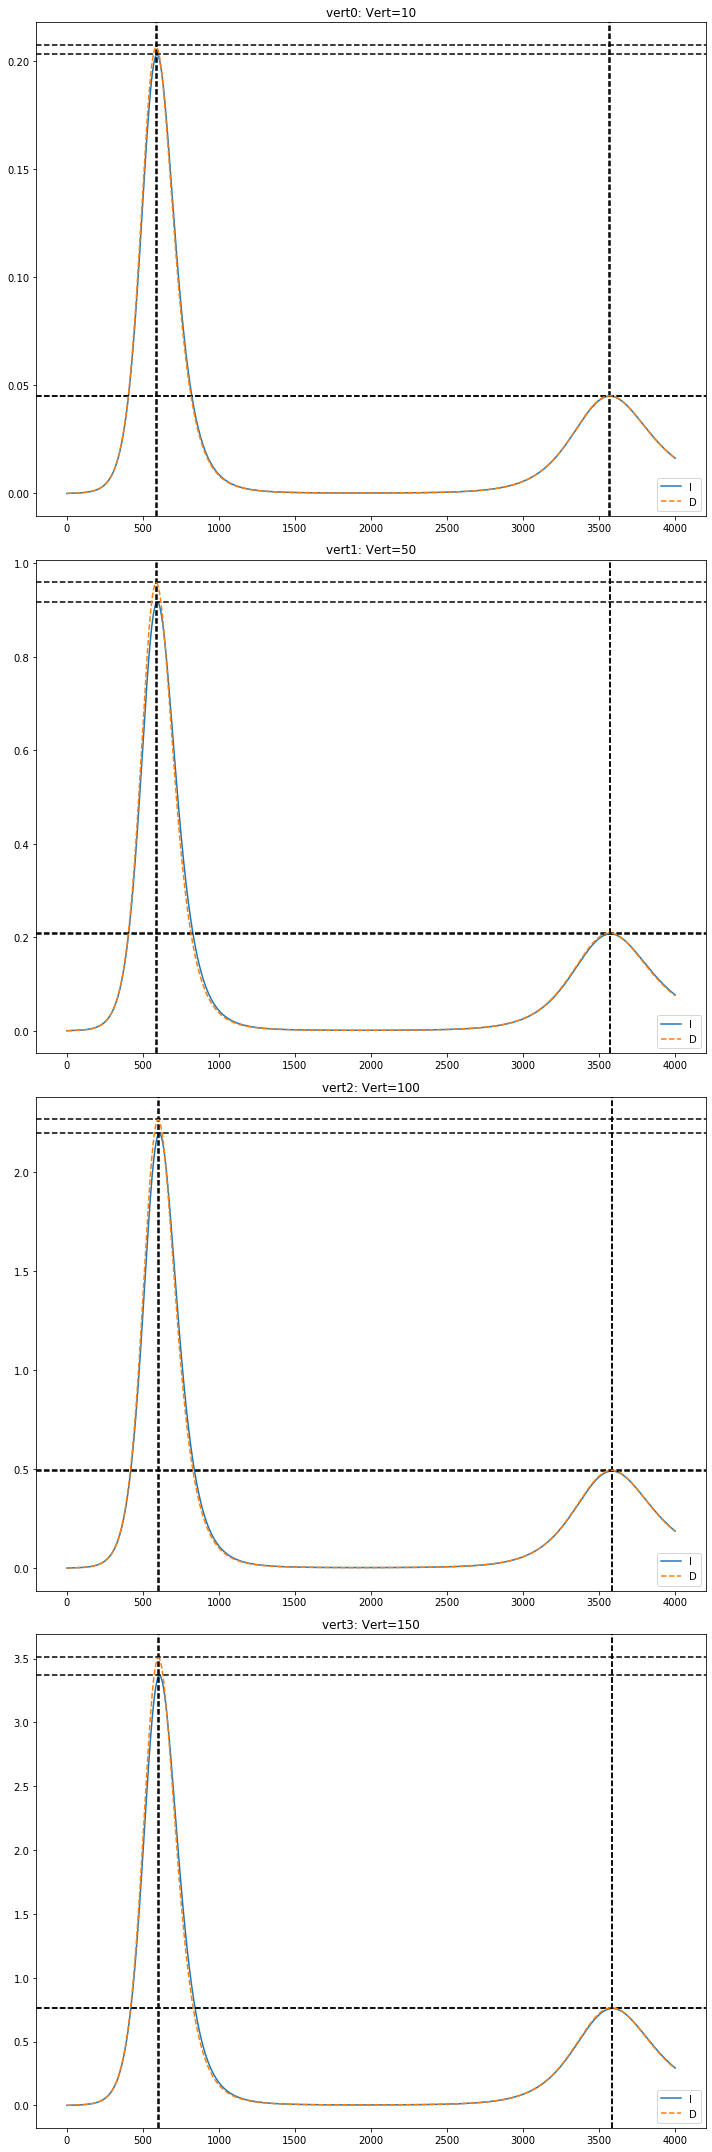

In [147]:
vertsweep_fig, ax = plt.subplots(no_vertices, 1, figsize=(10,30))
ax = ax.flatten()

for vert in range(no_vertices):
    comp=2
    ax[vert].plot(avg_sim_Sdata[vert][:, comp], label=comps[comp])
    ax[vert].axhline(mean_first_infection_wave[vert, 1], ls='--',ms=1, color='black' )
    ax[vert].axvline(mean_first_infection_wave[vert, 0], ls='--',ms=1, color='black' )
    
    ax[vert].axhline(mean_second_infection_wave[vert, 1], ls='--',ms=1, color='black' )
    ax[vert].axvline(mean_second_infection_wave[vert, 0], ls='--',ms=1, color='black' )
    
    ax[vert].axhline(mean_ref_first_infection_wave[vert, 1], ls='--',ms=1, color='black' )
    ax[vert].axvline(mean_ref_first_infection_wave[vert, 0], ls='--',ms=1, color='black' )
    
    ax[vert].axhline(mean_ref_second_infection_wave[vert, 1], ls='--',ms=1, color='black' )
    ax[vert].axvline(mean_ref_second_infection_wave[vert, 0], ls='--',ms=1, color='black' )
    ax[vert].plot(avg_ref_data[vert][:, comp], '--', label='{}'.format(ref_names[i]))
    
    ax[vert].set_title('vert{}: Vert={}'.format(vert,num_vertices[vert]))
    ax[vert].legend()
        
plt.tight_layout()

#### Compare Infection Wave Positions and Severity

In [154]:
mean_first_infection_wave[:, 1]

[10, 50, 100, 150]

In [158]:
mean_ref_first_infection_wave[:, 0]

array([586.        , 587.33333333, 600.        , 601.66666667])

In [184]:
std_second_infection_wave

array([[8.17856276e+00, 4.52792722e-03],
       [3.77123617e+00, 7.38602252e-03],
       [1.24721913e+00, 5.86226853e-02],
       [5.43650214e+00, 6.26381239e-02]])

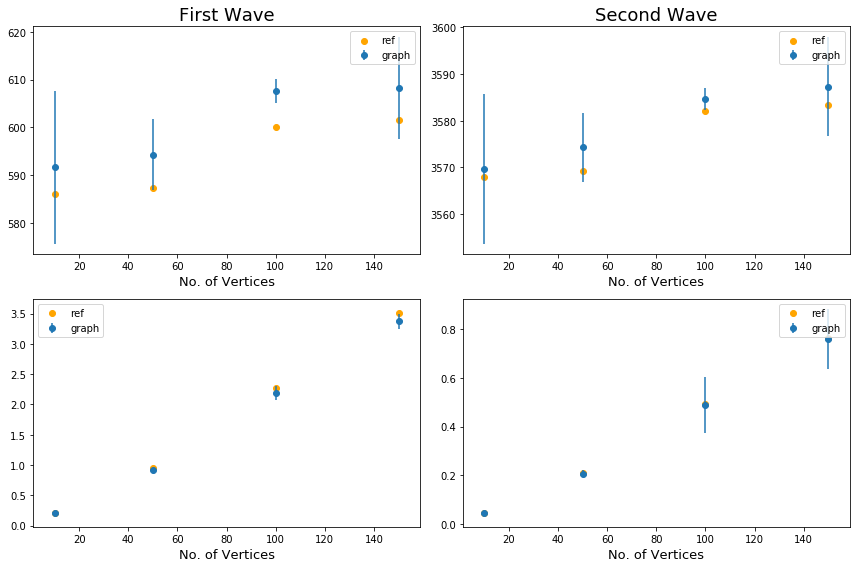

In [185]:
plt.rc('axes', titlesize=18)
plt.rc('axes', titlesize=18)
maxI_fig, ax = plt.subplots(2, 2, figsize=(12,8))
ax = ax.flatten()

ax[0].errorbar(num_vertices, mean_first_infection_wave[:, 0], yerr= 1.96 * std_first_infection_wave[:, 0], label='graph', fmt='o')
ax[2].errorbar(num_vertices, mean_first_infection_wave[:, 1], yerr=1.96 * std_first_infection_wave[:, 1], fmt='o', label='graph')

ax[0].scatter(num_vertices, mean_ref_first_infection_wave[:, 0], label='ref', color='orange')
ax[2].scatter(num_vertices, mean_ref_first_infection_wave[:, 1], label='ref', color='orange')

ax[1].errorbar(num_vertices, mean_second_infection_wave[:, 0], yerr= 1.96 * std_second_infection_wave[:, 0], label='graph', fmt='o')
ax[3].errorbar(num_vertices, mean_second_infection_wave[:, 1], yerr=1.96 * std_second_infection_wave[:, 1], fmt='o', label='graph')

ax[1].scatter(num_vertices, mean_ref_second_infection_wave[:, 0], label='ref', color='orange')
ax[3].scatter(num_vertices, mean_ref_second_infection_wave[:, 1], label='ref', color='orange')

ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()

ax[0].set_title("First Wave")
ax[1].set_title("Second Wave")

for i in range(4):
    ax[i].set_xlabel('No. of Vertices')

plt.tight_layout()

Calculate the standard deviation of product:

In [192]:
def stdxy(meanx, meany, stdx, stdy):
    return np.sqrt(meanx**2 * stdy**2 + meany**2 * stdx**2 + stdx**2 * stdy**2)

In [201]:
meanx = mean_first_infection_wave
meany = mean_ref_inv
stdx = std_first_infection_wave
stdy = std_ref_inv

In [202]:
stdxy(meanx[:, 0], meany[:, 0], stdx[:, 0], stdy[:, 0])

array([0.02193947, 0.01148886, 0.00539728, 0.01517996])

In [194]:
meanx

array([[5.91666667e+02, 2.03533735e-01],
       [5.94333333e+02, 9.17170612e-01],
       [6.07666667e+02, 2.19406829e+00],
       [6.08333333e+02, 3.37333891e+00]])

In [197]:
meanx

array([[5.91666667e+02, 2.03533735e-01],
       [5.94333333e+02, 9.17170612e-01],
       [6.07666667e+02, 2.19406829e+00],
       [6.08333333e+02, 3.37333891e+00]])

Show the percentage difference to the SEIR reference model:

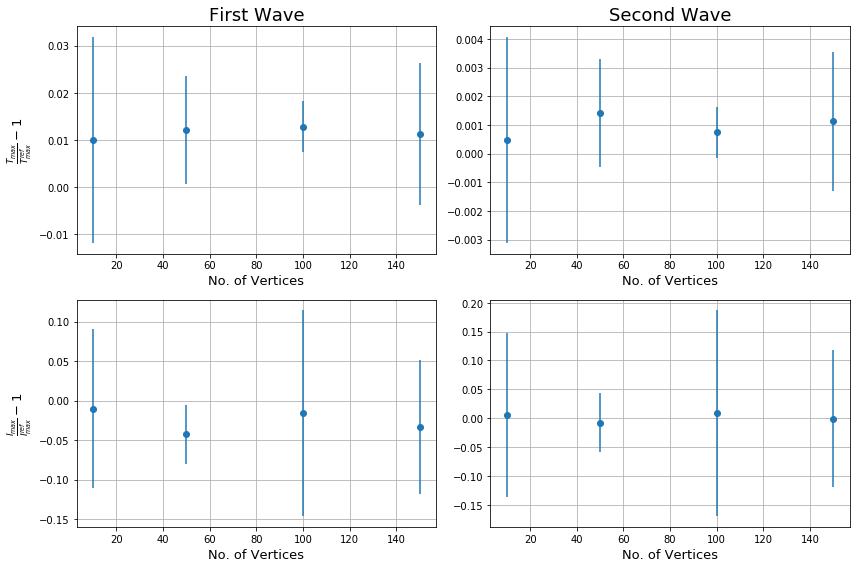

In [211]:
plt.rc('axes', labelsize=13)
plt.rc('axes', titlesize=18)
maxIratioref_fig, ax = plt.subplots(2, 2, figsize=(12,8))
ax = ax.flatten()

ax[0].errorbar(num_vertices, mean_first_infection_wave[:, 0] * mean_ref_inv[:, 0] - 1,\
              yerr = stdxy(mean_first_infection_wave[:, 0], mean_ref_inv[:, 0], std_first_infection_wave[:, 0], std_ref_inv[:, 0]), fmt='o')

ax[2].errorbar(num_vertices, mean_first_infection_wave[:, 1] * mean_ref_inv[:, 1] - 1,\
              yerr = stdxy(mean_first_infection_wave[:, 1], mean_ref_inv[:, 1], std_first_infection_wave[:, 1], std_ref_inv[:, 1]), fmt='o')

ax[1].errorbar(num_vertices, mean_second_infection_wave[:, 0] * mean_ref_inv_sec[:, 0] - 1,\
              yerr = stdxy(mean_second_infection_wave[:, 0], mean_ref_inv_sec[:, 0], std_second_infection_wave[:, 0], std_ref_inv_sec[:, 0]), fmt='o')


ax[3].errorbar(num_vertices, mean_second_infection_wave[:, 1] * mean_ref_inv_sec[:, 1] - 1,\
              yerr = stdxy(mean_second_infection_wave[:, 1], mean_ref_inv_sec[:, 1], std_second_infection_wave[:, 1], std_ref_inv_sec[:, 1]), fmt='o')



ax[0].set_title("First Wave")
ax[1].set_title("Second Wave")
ax[0].set_ylabel(r"$\frac{T_{max}}{T^{ref}_{max}} - 1$")
ax[2].set_ylabel(r"$\frac{I_{max}}{I^{ref}_{max}} - 1$")

for i in range(4):
    ax[i].set_xlabel('No. of Vertices')
    ax[i].grid()

plt.tight_layout()

plt.savefig(fig_path + name_convention + 'waves.pdf')